In [106]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree
mcstree:uproot.models.TTree.Model_TTree_v20
mcsangle:pl.DataFrame
dfana:pl.DataFrame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import uproot.models
import uproot.models.TTree


def get_dump(fname):

    # mcstree:uproot.models.TTree.Model_TTree_v20
    mcstree = uproot.open(fname)

    arr={}
    
    alldata:ak.Array
    alldata = mcstree.arrays()
    top = len(alldata)

    klist = ['run','subrun','event','isContained','len','trkpdg','E']
    nevts = [len(v) for v in alldata['azx'][:top]]
    for c in klist:
        if c in alldata.fields:
            a  = alldata[c][:top]
            arr[c] = np.repeat(a,nevts)
        
    ei = []
    ej = []
    for n in tqdm(nevts):
        _ei = np.arange(0,n*10,10)
        ei.append(_ei)
        ej.append(_ei+10)
    arr['ei'] = ak.ravel(ei)
    arr['ej'] = ak.ravel(ej)
            
    klist = ['azx','azy','avalid']
    for c in klist:
        a  = alldata[c][:top]
        arr[c] = ak.ravel(a)
    
    tangles = pd.DataFrame(arr)
    return pl.from_pandas(tangles)

mcs = get_dump('../data/mcparticle_dump3.root:t1')
mcs = mcs.with_columns(
    p = (pl.col("E")**2 - 0.1057**2).sqrt()
)
# mcsangle = mcsangle.with_columns(
#     ei = pl.col('ei'),
#     ej = pl.col('ej'),
# # ).with_columns(
# #     Ei = pl.col("E") - pl.col("ei")
# ).sort(selection_events())

100%|██████████| 128453/128453 [00:00<00:00, 379245.49it/s]


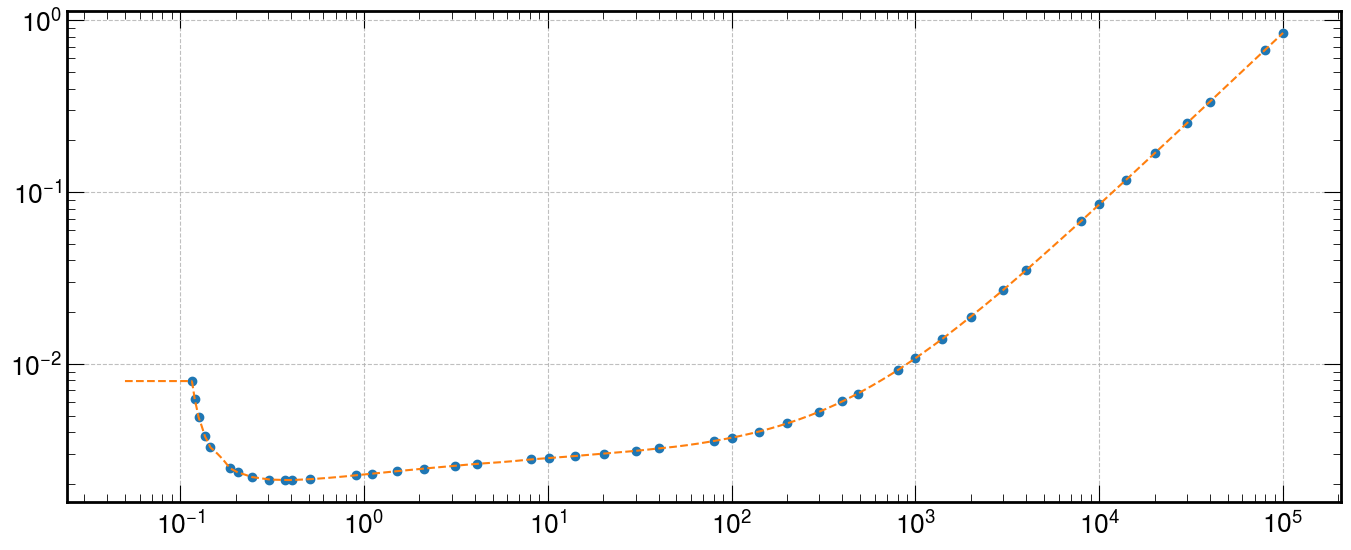

In [108]:
# 
dEdx = np.array([
    5.687, 4.461, 3.502, 2.731, 2.340, 1.771, 1.670, 1.570, 1.519, 1.508,
    1.510, 1.526, 1.610, 1.645, 1.700, 1.761, 1.829, 1.877, 1.991, 2.028,
    2.084, 2.149, 2.232, 2.304, 2.548, 2.663, 2.888, 3.224, 3.774, 4.332,
    4.808, 6.585, 7.730, 10.015, 13.494, 19.288, 25.147, 48.769, 60.675,
    84.472, 120.406, 180.375, 240.642, 482.918, 604.590, 
])*1.396*1e-3
E_GeV = np.array([
    0.115695, 0.119693, 0.125695, 0.135694, 0.145714, 0.185714, 0.205644,
    0.245698, 0.305658, 0.372031, 0.405711, 0.505671, 0.905689, 1.10606,
    1.50571, 2.10565, 3.1058, 4.10536, 8.10569, 10.1106, 14.1104, 20.1103,
    30.1102, 40.1101, 80.1101, 100.1, 140.1, 200.1, 300.1, 400.1, 484.6,
    800.1, 1000.0, 1400.0, 2000.0, 3000.0, 4000.0, 8000.0, 10000.0, 14000.0,
    20000.0, 30000.0, 40000.0, 80000.0, 1e+05
])
from scipy.interpolate import CubicSpline
# dEdx_vs_E = CubicSpline(E_GeV,dEdx)
E_inter = np.logspace(np.log10(0.05),5,2000)
dEdx_vs_E = np.interp(x=E_inter, xp=E_GeV, fp=dEdx)

plt.plot(E_GeV, dEdx, 'o')
plt.plot(E_inter, dEdx_vs_E, '--')
plt.yscale('log')
plt.xscale('log')


In [1]:
import numba as nb
@nb.njit
def compute_eloss(E, ei, ej):
    Eij = []
    Ej = []
    Elost = []
    Elost_mip = []
    _dEj=0
    aux=0
    for Eref, step, nextstep in zip(E, ei, ej):
        if step==0:
            if _Elost != 0:
                for _ in range(aux):
                    Elost.append(_Elost)
            _Eij  = Eref
            _dEj = 0
            _Elost = 0
            _Ej = 0
            aux = 1
        else:
            _Eij = _Ej
            aux+=1
        _dEj = np.interp(_Eij, E_GeV, dEdx)*10
        _Elost += _dEj
        _Ej = _Eij - _dEj
        Eij.append(_Eij)
        Ej.append(_Ej)

    for _ in range(aux):
        Elost.append(_Elost)
    return Eij, Ej, Elost


In [2]:

pl.Config().set_tbl_rows(20)
pl.Config().set_tbl_cols(20)
mcsangle = mcs.sort(selection_events('ei'))
tmp = mcsangle.select(selection_events(['E', 'ei','ej' ]))
arrtmp = tmp.to_dict()
arr = {}
for k in arrtmp.keys():
    arr[k] = arrtmp[k].to_numpy()
Eij, Ej, Elost = compute_eloss(arr['E'], arr['ei'], arr['ej'])
arr['Ei'] = np.array(Eij)
arr['Ej'] = np.array(Ej)
arr['Elost'] = np.array(Elost)
tmppd = pd.DataFrame(arr)
plEi = pl.from_pandas(tmppd)
plEi = plEi.select(selection_events(['ei', 'Ei', 'Ej','Elost' ]))
mcsangle = mcsangle.join(plEi, on=selection_events('ei'), how='inner')
mcsangle

NameError: name 'pl' is not defined

In [111]:
tmpcount = mcsangle.sort(
    selection_events('ei')
).group_by(selection_events()).agg(
    pl.len(),
)
tmp = mcsangle.join(tmpcount, on=selection_events())
tmp.filter(
    pl.col("Ei")<0.1057
).group_by(selection_events()).agg(
    total = pl.col('len').first(),
    minors=pl.len(),
    E=pl.col('E').first()
).with_columns(
    frac = pl.col('minors')/pl.col('total')
)


run,subrun,event,total,minors,E,frac
i32,i32,i32,f64,u32,f64,f64
1499,1,65845,995.543816,2,2.333627,0.002009
1498,1,25659,779.387436,1,1.825043,0.001283
1794,1,25075,570.151981,1,1.340911,0.001754
1497,1,40746,761.080667,1,1.78939,0.001314
1498,1,74064,648.331563,1,1.53391,0.001542
1498,1,78050,1159.155253,3,2.7263,0.002588
50231162,1,96780,901.358199,2,2.158715,0.002219
50231162,1,85443,467.652303,2,1.893453,0.004277
50231162,1,11860,723.349225,1,1.748908,0.001382


In [112]:
# code who found duplicates :) 
# mcsangle.group_by(selection_events()).agg(
#     len1 = pl.col('ei').len(),
#     len2 = pl.col('ei').unique().len()
# ).filter(pl.col('len1')!=pl.col('len2'))
# tmp.filter(
#     (pl.col('run')==1497),
#     (pl.col('subrun')==1),
#     (pl.col('event')==3064),
# )

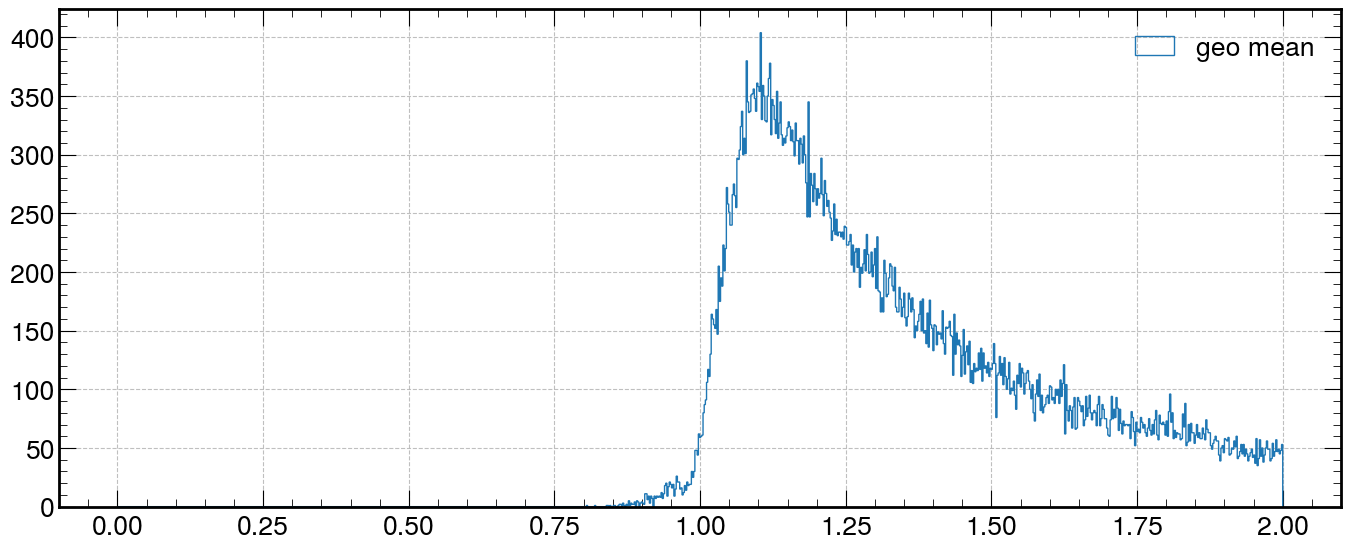

In [113]:
dftmp = mcsangle.sort(selection_events('ei')).group_by(selection_events()).agg(
    pl.col("isContained").last(),
    E = pl.col("E").last()-0.1057,
    Elost = pl.col("Elost").last(),# - pl.col('Ei').last(),
    nsteps = pl.col('ei').len(),
    ei = pl.col('ei').first(),
).with_columns(
    diff = ((pl.col("E"))/pl.col('Elost')),
# ).filter(pl.col("isContained")
# ).filter(
#     pl.col('ei') < 30
)
plt.hist(dftmp['diff'], bins=np.linspace(0.,2,1000), histtype='step', label='geo mean');
plt.legend()
# plt.xscale('log')
mcsangle = mcsangle.join(dftmp.select(selection_events(['diff','nsteps'])), on=selection_events())

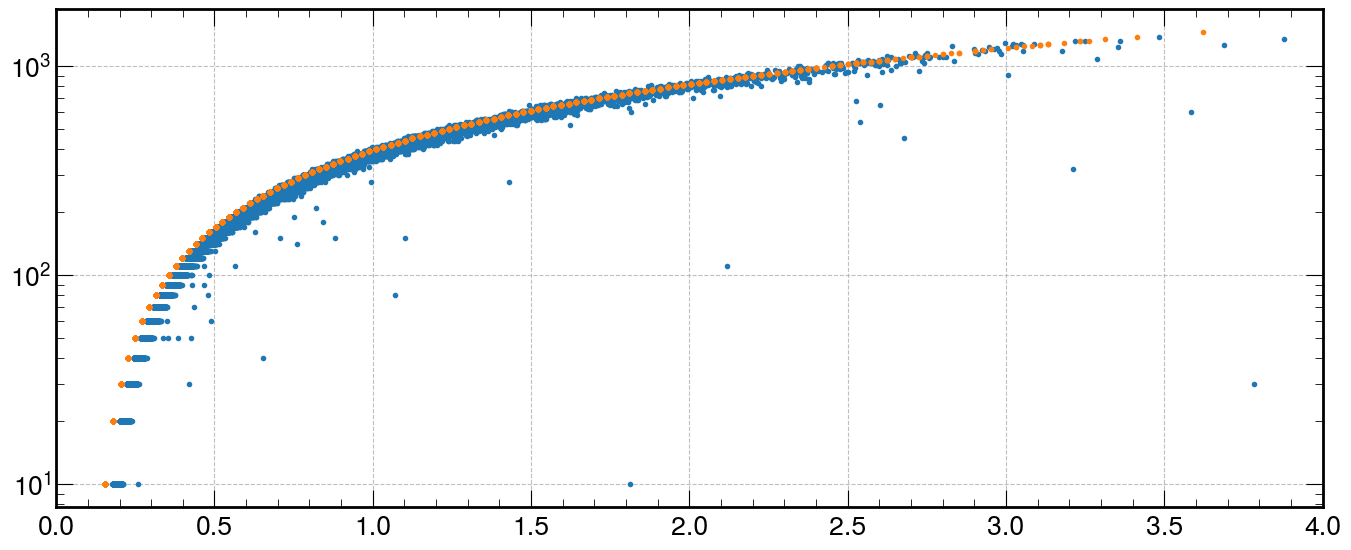

In [114]:
len_cm = np.array([9.833E-1, 1.786E0, 3.321E0, 6.598E0, 1.058E1,
          3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
          2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3,
          1.758E3, 2.297E3, 4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4, 4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5])/1.396
 
KE_GeV = np.array([10, 14, 20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
          4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
          200000, 300000, 400000])/1e3
from scipy.interpolate import CubicSpline
KE_by_len = CubicSpline(len_cm,KE_GeV)
tmp = mcsangle.group_by(selection_events()).agg(
    pl.col('E').first(),
    pl.col('isContained').first(),
    pl.len()*10,
).filter(pl.col('isContained')).with_columns(
    Erange = pl.col('len').map_elements(lambda x: KE_by_len(x), return_dtype=pl.Float32) + 0.1057
)
plt.plot(tmp['E'],tmp['len'],'.')
plt.plot(tmp['Erange'],tmp['len'],'.')
plt.xlim(0,4)
# plt.xscale('log')
plt.yscale('log')

In [115]:
# mcsangle.group_by(selection_events()).agg(
#         Einf = pl.col("Ei").filter((pl.col("Ei").is_infinite())).count(),
#         Ei = pl.col("Ei").count(),
#         p = pl.col("p").first(),
#         pdg = pl.col('trkpdg').first(),
#         isContained = pl.col('isContained').first(),
#         # pl.col("Ei"),
#         # pl.col('ei'),
#     ).filter(pl.col('Einf')>0).sort(selection_events())
# mcsangle

/tmp/ipykernel_1371161/1710450788.py:31: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus,hycenters, hh[aux],p0=[0,20,20], sigma=1/np.sqrt(hh[aux]))
/tmp/ipykernel_1371161/1710450788.py:48: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(gaus,hycenters, v,p0=[0,20,20], sigma=1/np.sqrt(v))


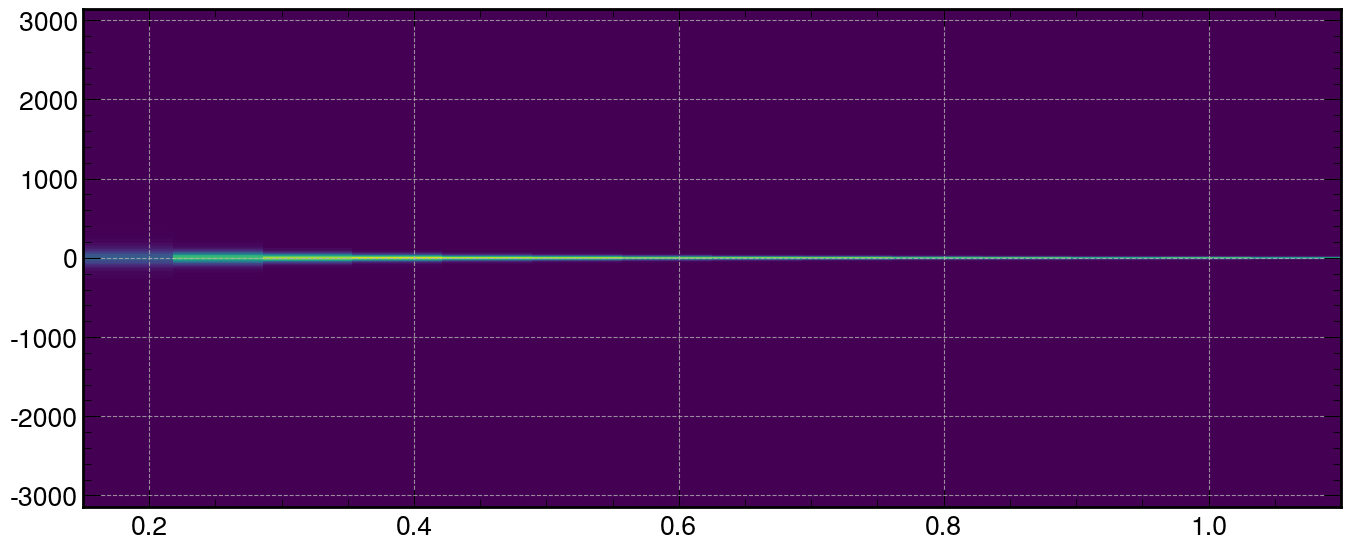

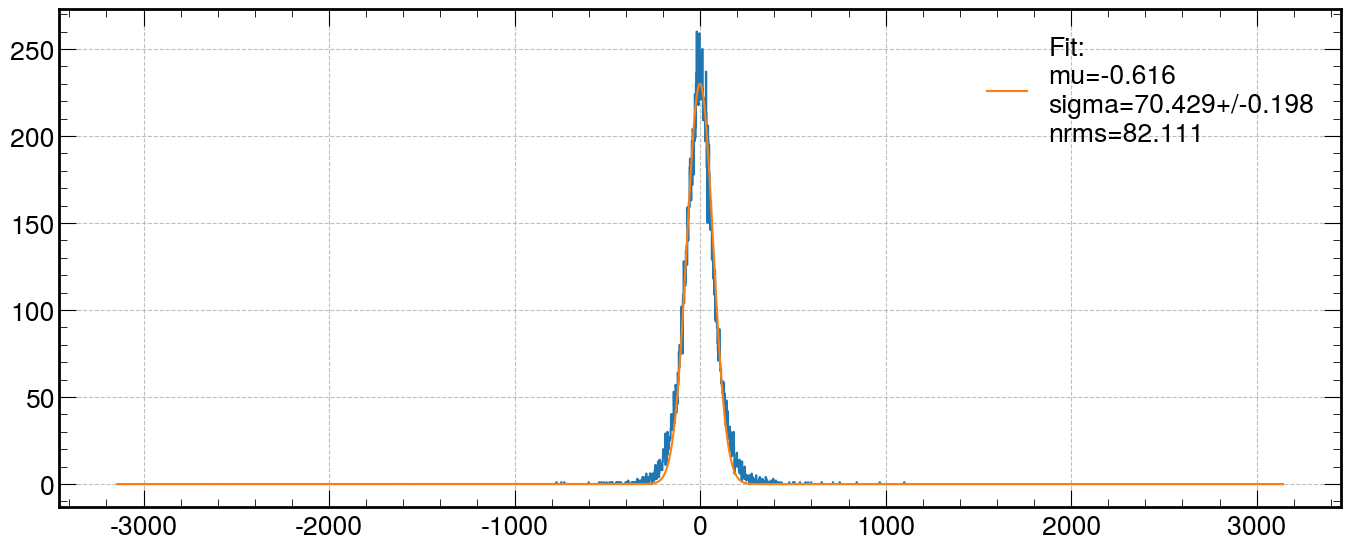

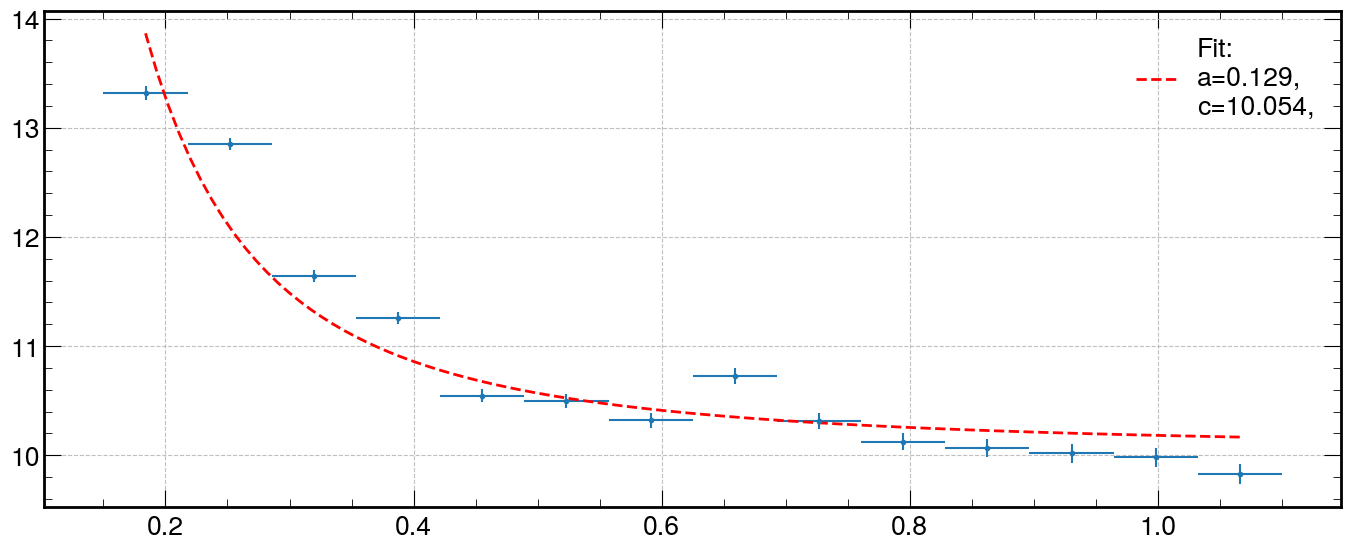

In [486]:
from scipy.optimize import curve_fit
def gaus(x, u, s, a):
    return (a/np.sqrt(2*np.pi*s*s))*np.exp(-((x-u)/s)**2/2)

def fit_s2(x, a, c):
    return (a/x**2+c)

def compute_s2(p, rms):
    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    beta = np.sqrt(1 - ((m_muon*m_muon)/(p*p + m_muon*m_muon)))
    const =  (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return p*beta*rms/const
dfc = mcsangle.filter(
    pl.col('ei') < 30
)
binsx = np.linspace(0.15,1.1,15)
rms, _, _ = binned_statistic(np.sqrt(dfc['Ei']**2-0.1057**2), dfc['azx'], "std", binsx)
count, _, _ = binned_statistic(np.sqrt(dfc['Ei']**2-0.1057**2), dfc['azx'], "count", binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
hh, hxe, hye, _ = plt.hist2d(dfc['p'], dfc['azx'], bins=[binsx, np.linspace(-3141.5,3141.5,3141)] );


aux = 0
plt.figure()
hycenters = (hye[:-1] + hye[1:])*0.5
plt.step(hycenters, hh[aux])
popt, pcov = curve_fit(gaus,hycenters, hh[aux],p0=[0,20,20], sigma=1/np.sqrt(hh[aux]))
perr = np.sqrt(np.diag(pcov))
plt.plot(hycenters, gaus(hycenters, *popt), label = f"Fit:\nmu={popt[0]:5.3f}\nsigma={popt[1]:5.3f}+/-{perr[1]:5.3f}\nnrms={rms[aux]:5.3f}")
plt.legend()


plt.figure()
nanrms = rms[~np.isnan(rms)]
nancenters = bins_center[~np.isnan(rms)]
nancount = count[~np.isnan(rms)]

nancenters = (hxe[:-1] + hxe[1:])*0.5
ercenter = (binsx[1:] - binsx[:-1])*0.5
nanrms = []
nancount = []
errms = []
for v, c in zip(hh, count):
    popt, pcov = curve_fit(gaus,hycenters, v,p0=[0,20,20], sigma=1/np.sqrt(v))
    nanrms.append(abs(popt[1]))
    perr = np.sqrt(np.diag(pcov))
    _errms = np.sqrt(perr[1]**2 + popt[1]**2/(2*c-2))
    errms.append(_errms)
    
s2 = compute_s2(nancenters, nanrms)
errS2 = compute_s2(nancenters, errms)
plt.errorbar(nancenters, s2, errS2, ercenter, '.' )
popt, pcov = curve_fit(fit_s2, nancenters, s2, p0=[0.1,11], sigma=np.ones_like(s2))#, sigma=1/np.sqrt(heigths))
# plt.plot(nancenters, func(nanrms, *[0.1,11]), 'r--', label="Fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," % tuple(popt[:2]), lw=2)
nancenterfit = np.linspace(nancenters[0], nancenters[-1],100)
plt.plot(nancenterfit, fit_s2(nancenterfit, *popt), 'r--', label="Fit:\n" r"a=%5.3f," "\n" r"c=%5.3f," % tuple(popt), lw=2)
plt.legend()
# plt.xscale('log')



/home/henrique/.local/lib/python3.10/site-packages/polars/series/series.py:1416: RuntimeWarning: invalid value encountered in sqrt
  lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs),


1.1446678510819108

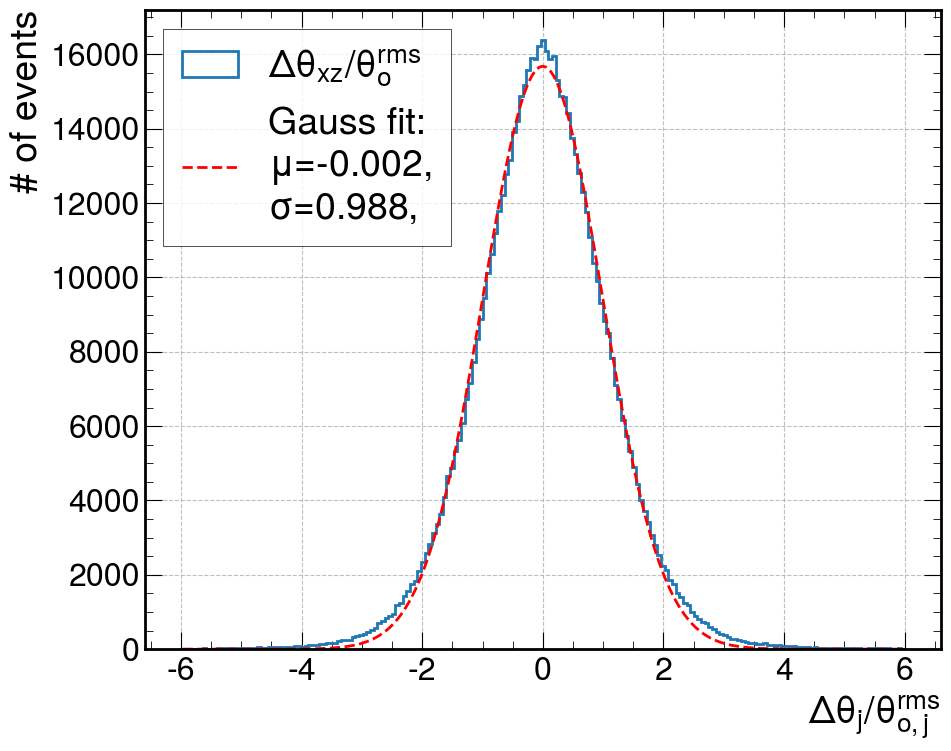

In [200]:
def compute_rms(p=None, _ei=None):
    if p is None: 
        p = pl.col('p')
    if _ei is None: 
        # _ei = pl.col('ei'root)
        _ei = pl.col('Ei')
    
    a = 0.129
    c = 10.054

    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    nonrel_Etot = np.sqrt(p*p + m_muon*m_muon)
    # nonrel_Eij = nonrel_Etot - _ei*0.0021
    nonrel_Eij = _ei

    nonrel_pij = np.sqrt(nonrel_Eij*nonrel_Eij - m_muon*m_muon)
    beta = np.sqrt(1 - ((m_muon*m_muon)/(nonrel_pij*nonrel_pij + m_muon*m_muon)))
    tH0 = ( (a/nonrel_pij**2 + c) / (nonrel_pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
    return tH0

mcsangle = mcsangle.with_columns(
    rms = ( compute_rms()**2 + 0**2 ).sqrt(),
    theta = (pl.col('azx')**2 + pl.col('azy')**2).sqrt(),
    seg = (pl.col('ej')/0.0021)
    # theta = (1./(1.+pl.col('azx').tan()**2+pl.col('azy').tan()**2).sqrt()).arccos()#*pl.col('azx').sign()
    # theta = ((pl.col('azx')/1000).cos()*(pl.col('azy')/1000).cos()).arccos()*1000*(pl.col('azx')/1000).cos().sign()
)

df = mcsangle
dfplot = df#.filter(pl.col("E")<1)#.filter((pl.col('azx')/pl.col('rms')).abs()>0.0007)
dfplot = df.filter((pl.col('azx')).abs()>-1).filter(
    pl.col("isContained") == True
# ).filter(
#     (pl.col('E')-0.1057)/pl.col("Elost")>2
# ).filter(
#     pl.col('Ei') > 0.2
# ).filter(
#     pl.col('Ei') < 1
# ).filter(
#     pl.col('trkpdg').abs()==13
).filter(
    pl.col('avalid')==True
)

dfplotnotend = dfplot.group_by(selection_events()).agg(
    pl.col('ei').head(pl.col('ei').len())
    # pl.col('ei').head(3)
).filter(
    pl.col('ei').len()>0
).explode('ei')
dfplot = dfplot.join(dfplotnotend, on=selection_events('ei'))
plt.figure(figsize=(10,8))
binsx = np.linspace(-6,6,200)
# heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms'])*np.sqrt(2), bins=binsx, histtype='step', label=r'$\sqrt{2} \times \Delta\theta_{xz}/\theta^{rms}_o$',lw=2,color='k');
heigths, hedges, _ = plt.hist((dfplot['azy']/dfplot['rms']), bins=binsx, histtype='step', label=r'$\Delta\theta_{xz}/\theta^{rms}_o$',lw=2);
hcenters = (hedges[1:] + hedges[:-1])*0.5
# cfitlim = abs(hcenters)<1.5
# hcenters = hcenters[cfitlim]
# heigths = heigths[cfitlim]
popt, pcov = curve_fit(gaus, hcenters, heigths, p0=[0,1,35000])#, sigma=1/np.sqrt(heigths))
perr = np.sqrt(np.diag(pcov))
# popt[1] = popt[1]/np.sqrt(2)
plt.plot(hcenters, gaus(hcenters, *popt), 'r--', label="Gauss fit:\n" r"$\mu$=%5.3f," "\n" r"$\sigma$=%5.3f," % tuple(popt[:2]), lw=2)
plt.tick_params(labelsize=23)
plt.xlabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.ylabel('# of events', fontsize=27)
# plt.yscale('log')
legend = plt.legend(frameon=True, fontsize=27, fancybox=False, loc='upper left')
legend.get_frame().set_edgecolor('k')
legend.get_frame().set_linewidth(0.6)
(dfplot['azx']/dfplot['rms']).drop_nans().std()


In [201]:
# Example bad reconstruction, 70,1 is a muons escaping, llhd and range give same result
dfsmalls = dfplot.group_by(selection_events()).agg(
    azx_total = pl.len(),
    azx_small = pl.col('azx').filter((pl.col('azx')/pl.col('rms')).abs()<0.07).count(),
    len = pl.col('len') .first(),
    E = pl.col('E').first()
).with_columns(
    frac = pl.col('azx_small')/pl.col('azx_total')
).filter(pl.col("azx_small")>0)
# df
dfsmalls.describe()

statistic,run,subrun,event,azx_total,azx_small,len,E,frac
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",21976.0,21976.0,21976.0,21976.0,21976.0,21976.0,21976.0,21976.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",7.6700e6,1.0,48531.371678,20.142747,1.719967,233.211123,0.654393,0.135312
"""std""",1.8066e7,0.0,28901.71583,15.784953,1.151952,193.308799,0.419945,0.136423
"""min""",1453.0,1.0,1.0,1.0,1.0,0.65568,0.179445,0.012987
"""25%""",1499.0,1.0,24002.0,9.0,1.0,105.219916,0.369422,0.060606
"""50%""",1500.0,1.0,47677.0,16.0,1.0,181.471869,0.534381,0.097561
"""75%""",1794.0,1.0,73362.0,27.0,2.0,304.469148,0.807268,0.157895
"""max""",5.0231162e7,1.0,100000.0,110.0,11.0,7325.44648,12.752942,1.0


Text(0, 1, '# of events')

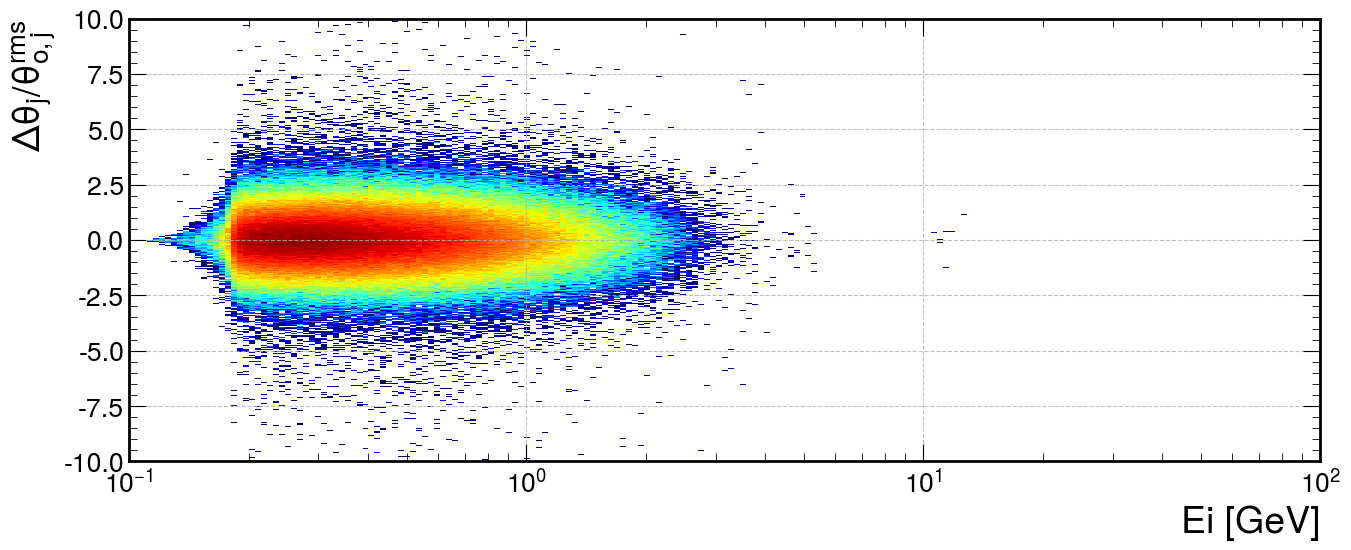

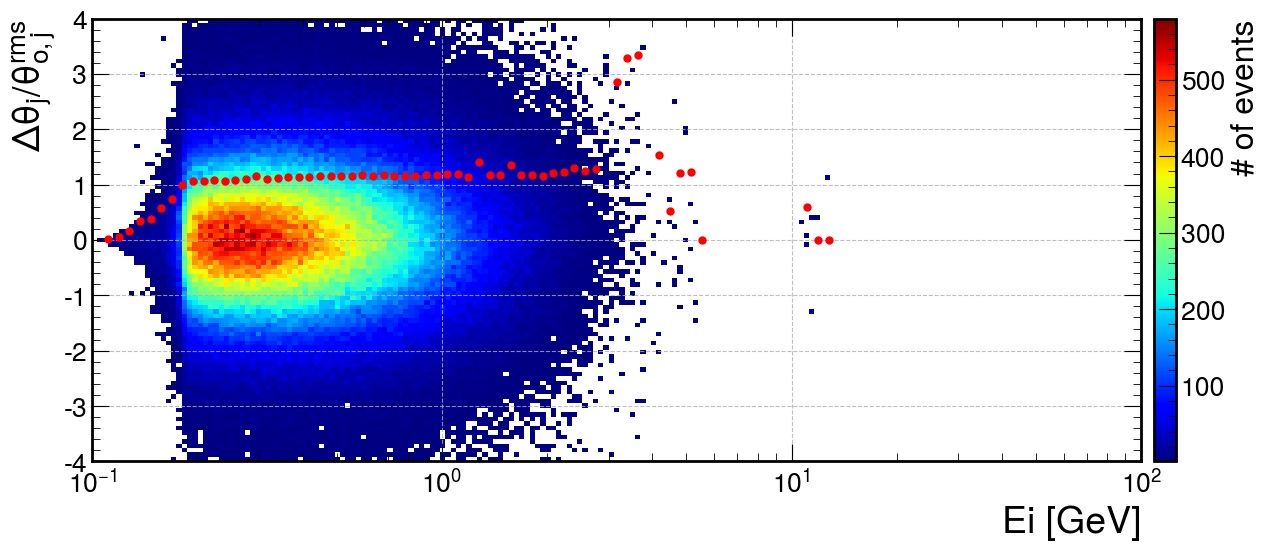

In [202]:

plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-10,10,500)],cmap=plt.cm.jet, norm='log', label='Some');
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
plt.xscale('log')

plt.figure()
binsx = np.logspace(-1,2,100)
val, _, _ = binned_statistic(dfplot['Ei'], dfplot['azx']/dfplot['rms'], "std", binsx)
bins_center = 0.5*(binsx[:-1] + binsx[1:])
bins_width = binsx[1:]- binsx[:-1]
plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,200), np.linspace(-4,4,100)], cmap=plt.cm.jet, cmin=1)
lines = plt.plot(bins_center, val, 'o', markersize=5, color='r',)
# plt.hist2d(dfplot['Ei'], dfplot['azx']/dfplot['rms'], bins=[np.logspace(-1,2,100), np.linspace(-10,10,100)], cmap=plt.cm.jet, cmin=1)
# fakeE = np.logspace(-1,2,200)
# fakeEi = np.zeros_like(fakeE)
# fakeRMS = compute_rms(fakeE, fakeEi)
# plt.plot(fakeE,fakeRMS, '--', color='red', lw=2)
plt.xlabel('Ei [GeV]', fontsize=27)
plt.ylabel(r'$\Delta\theta_j/\theta^{rms}_{o, j}$', fontsize=27)
# plt.ylabel(r'$\Delta\theta_{zx}$', fontsize=27)
plt.xscale('log')
cbar = plt.colorbar(pad=0.01)
cbar.ax.set_ylabel('# of events', fontsize=23)
# dfplot.filter(get_event(70,1))
# anatree.nu.filter(get_event(70,1))["RecoLepEnNumu_mcs_llhd"]

In [328]:
# pl.Config.set_tbl_rows(40)
# dfout.group_by(selection_events()).agg(
#     pl.count(),# plot_res_vs_energy(dftemp['E'],
#                    dftemp['RecoLepEnNumu_range'],
#                    label=r'CSDA')
#     pl.all(),
# ).explode(pl.all().exclude(selection_events(['count']))).sort('subrun').sort('count', descending=True).head(40)

dfllhd = df.group_by(selection_events()).agg(
    pl.all().exclude('seg','len','p', 'isContained'),
    seg = pl.col('seg').first(),
    len = pl.col('len').first(),
    p = pl.col('p').first(),
    isContained = pl.col('isContained').first(),
    nvalids = pl.col('avalid').filter(pl.col('avalid')==True).len(),
).filter(
    pl.col('nvalids') > 0
).sort(selection_events())
vals = dfllhd.select(['theta', 'ei', 'ej', 'p', 'subrun', 'event', 'azx', 'azy','len', 'avalid', 'run', 'isContained', 'Ei']).to_numpy()
thetas = vals[:,0]
ei = vals[:,1]
ej = vals[:,2]
trueP = vals[:,3]
srun = vals[:,4]
evt = vals[:,5]
azx = vals[:,6]
azy = vals[:,7]
trklen = vals[:,8]
avalid = vals[:,9]
run = vals[:,10]
isContained = vals[:,11]
Ei = vals[:,12]


    

In [204]:
import numba as nb
@nb.njit
def llhd(evDT, evValid, correct, p, res):
    # a = 0.1049
    # c = 11.0038
    a = 0.129
    c = 10.054

    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057
    Etot = np.sqrt(p*p + m_muon*m_muon)

    result = 0
    dei = 0
    penality = False
    Eij = Etot
    for idx in nb.prange(len(evDT)):
        dth = evDT[idx]
        Eij = Eij - dei
        if Eij <= m_muon:
            penality=True
            Eij = m_muon+0.01
            dei = 0
        else:
            dei = np.interp(Eij, E_GeV, dEdx)*stepsize
        # if nonrel_Eij < m_muon:
        #     return 99999

        pij = np.sqrt(Eij*Eij - m_muon*m_muon)
        beta = np.sqrt(1 - ((m_muon*m_muon)/(pij*pij + m_muon*m_muon)))
        tH0 = ( (a/pij**2 + c) / (pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
        if correct:
            tH0 *= np.sqrt(2)
        rms_square = (tH0**2 + res**2)
        # if evValid[idx] is False:
        #     continue
        prob = -0.5*np.log(2*np.pi) - 0.5*np.log(rms_square) - 0.5*dth*dth/rms_square
        if penality:
            prob -= 2*rms_square
        result-=2*prob
    return result
def call_llhd(p:float, res:float, ev:int):
    global DT
    global Valid
    global correct
    
    ev = int(ev)
    result = 0
    result = llhd(DT[ev], Valid[ev], correct, p, res)
    return result


idx: 0, run: 1453,  subrun: 1, event: 7, p = 0.32, contained = True


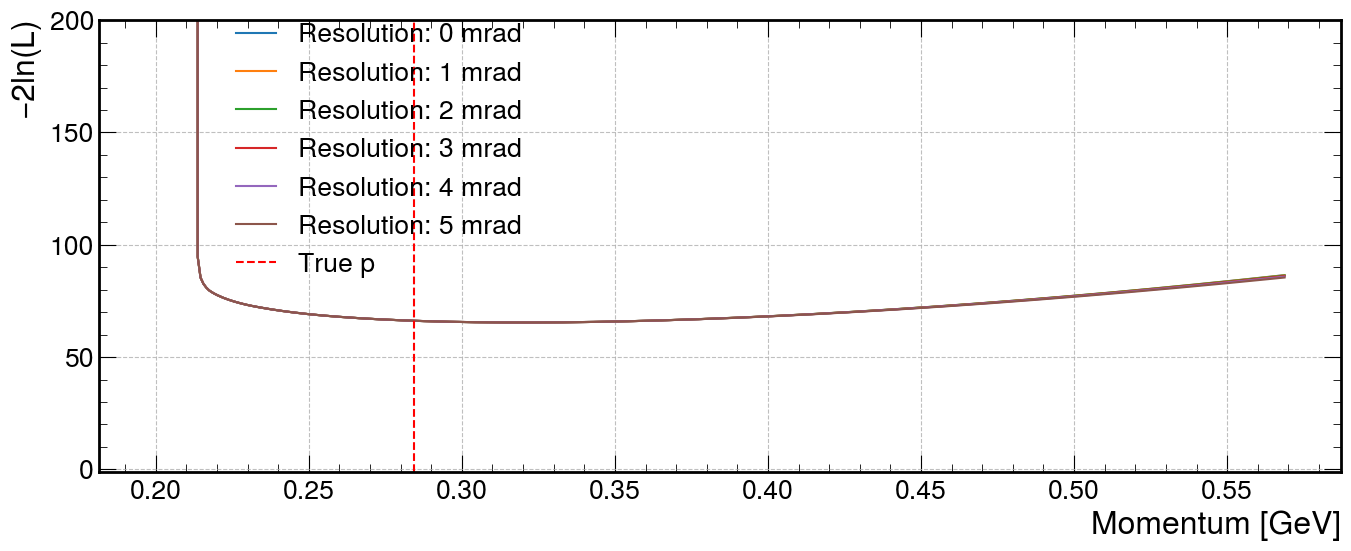

In [205]:
res_scan = [ r for r in range(0,6,1)]
res = [[] for _ in res_scan]
ptry = [[] for _ in res]
idx=0
DT = thetas#[idx]/np.sqrt(2)
Valid = avalid
correct = True
# DT = azy[idx]
for r,i in enumerate(res_scan):
    Erange = KE_by_len(len(DT[idx])*10) + 0.1057
    Prange = np.sqrt(Erange**2 - 0.1057**2)
    for x in np.linspace(Prange*0.8, 2*trueP[idx], 400):
        ll = call_llhd(x, r, idx)
        res[i].append(ll)
        ptry[i].append(x)
    plt.plot(ptry[i], res[i], label=f"Resolution: {r:.0f} mrad")
# plt.yscale('log')
plt.ylim(-1,200)
plt.axvline(trueP[idx], color='r', linestyle='--', label='True p')
plt.ylabel(r'$-2ln(\mathcal{L})$')
plt.xlabel('Momentum [GeV]')
axbox = plt.gca().get_position
plt.legend(loc=(0.1,0.4),ncol=1)
print(f'idx: {idx}, run: {run[idx]},  subrun: {srun[idx]}, event: {evt[idx]}, p = {ptry[0][np.argmin(res[0])]:.2f}, contained = {isContained[idx]}')

In [206]:
mcsangle.filter(filter_event(1453,1,372))

run,subrun,event,isContained,len,trkpdg,E,ei,ej,azx,azy,avalid,p,Ei,Ej,Elost,rms,theta,seg
i32,i32,i32,bool,f64,i32,f64,i64,i64,f64,f64,bool,f64,f64,f64,f64,f64,f64,f64
1453,1,372,false,43.456269,2212,5.353801,0,10,-2.19722,-0.8743,false,5.352757,5.353801,5.327101,0.053389,1.568174,2.364779,4761.904762
1453,1,372,false,43.456269,2212,5.353801,10,20,-0.102847,-0.040769,false,5.352757,5.327101,5.300412,0.053389,1.576047,0.110633,9523.809524


In [207]:
from iminuit import Minuit, cost
from iminuit.util import describe


def lazy_min(start=0, maxevt=None, deltatheta = None, resval = 0, fixres = True, docorrect = True):
    global trueP
    global DT
    global Valid
    global correct
    global trklen
    
    
    
    DT = deltatheta
    correct = docorrect
    
    indexes = [ i for i, _ in enumerate(trueP)]

    if maxevt == None:
        maxevt = len(trueP)
    p_ = trueP[start:maxevt]
    indexes = indexes[start:maxevt]
    
    trueE = np.zeros_like(p_)
    recoE = np.zeros_like(p_)
    fitS = np.zeros_like(p_)
    for idx, ev in enumerate(tqdm(indexes)):
        pt = p_[idx]
        pars = ['p', 'res', 'ev']
        Erange = KE_by_len(len(DT[idx])*10) + 0.1057
        Prange = np.sqrt(Erange**2 - 0.1057**2)
        m = Minuit(call_llhd, p=2*Prange, res=resval, ev=ev)
        m.tol = 0.01/2.
        m.fixed['ev'] = True
        m.limits['p']=(0.8*Prange,100)
        m.limits['res']=(0,100)
        m.fixed['res'] = fixres
        m.strategy.strategy = 2
        m.migrad()
        vals = [m.values[par] for par in pars]
        trueE[idx] = np.sqrt(pt**2 + 0.1057**2)
        recoE[idx] = np.sqrt(vals[0]**2 + 0.1057**2)
        fitS[idx] = m.fmin.is_valid
    trueE = trueE.astype(float)
    recoE = recoE.astype(float)
    return trueE, recoE , fitS


In [227]:
trueE, recoE, fitS = lazy_min(0,None, thetas,0,True,True)
np.all(fitS==True)

100%|██████████| 123676/123676 [00:40<00:00, 3059.32it/s]


False

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x600 with 0 Axes>

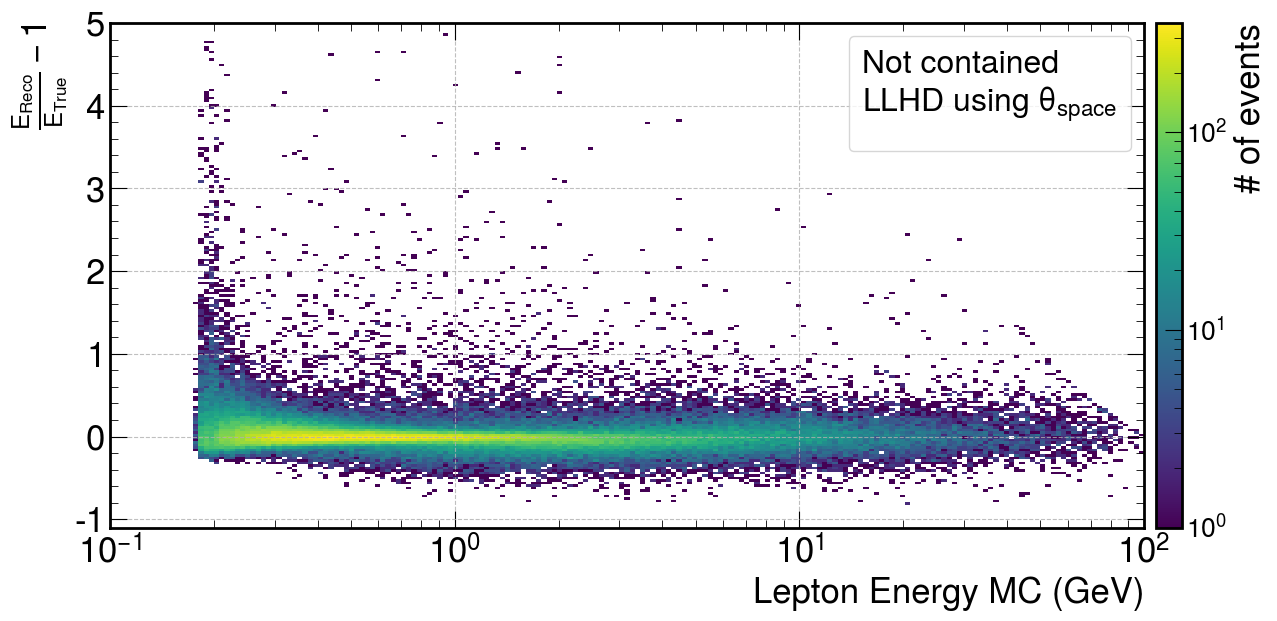

<Figure size 1400x600 with 0 Axes>

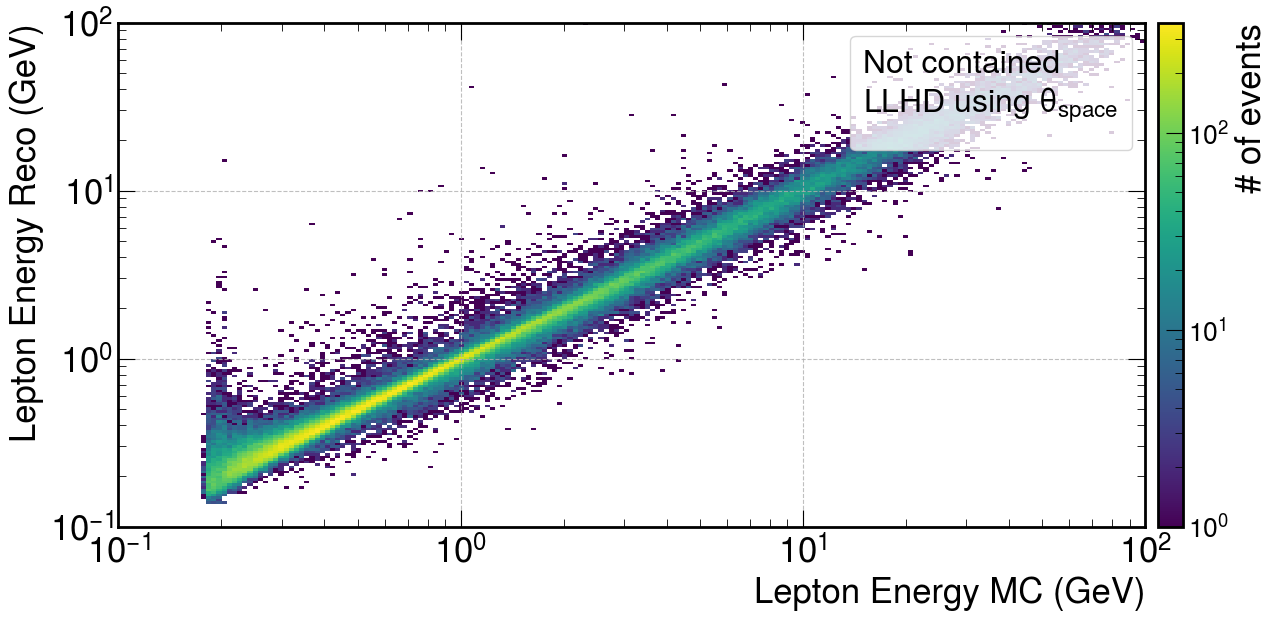

In [228]:
def display_en_reco(x,
                    y,
                    actualx = None,
                    binse = np.logspace(-1,2,200),
                    binsy = np.linspace(-1.1,5,200),
                    xlabel = 'Lepton Energy MC (GeV)',
                    ylabel = r'$\frac{E_{Reco}}{E_{True}} - 1$',
                    fontsize=25,
                    lmethod='',
                    makefrac=True,
                    xscale='log',
                    yscale='linear',
                    figsize=(14,6.7)):
    plt.figure()
    plotx = x
    if not actualx is None:
        plotx = [v for v in actualx]
    plt.figure(figsize=figsize)
    if makefrac:
        ploty = (y/x-1)
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    else:
        ploty = y
        plt.hist2d(plotx, ploty, bins=[binse,binsy], norm='log');
    fontsize=25
    if makefrac: plt.plot([0,100],[0,100], '--', c='r')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('# of events', fontsize=fontsize)
    if lmethod:
        legend = plt.legend(frameon=True, title=lmethod, loc='upper right')
    plt.plot();
display_en_reco(trueE,
                recoE,
                # actualx=recoE_nosqrt
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(trueE,
                recoE,
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )


(0.0, 35.0)

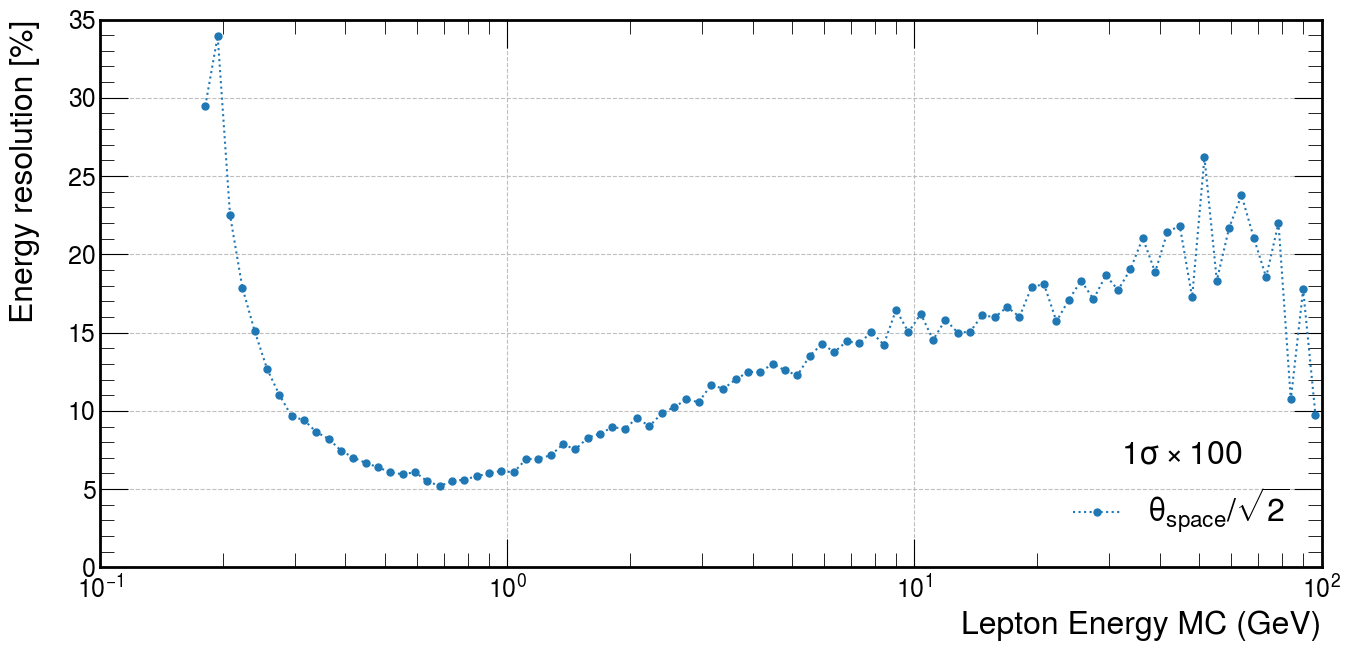

In [232]:
from scipy.stats import binned_statistic
def plot_res_vs_energy(varx, vary, actualx=None, binsx = np.logspace(-1,2,100), fmt = '.:', infotype='std', **kwargs):
    vary = (vary/varx-1)
    if not actualx is None:
        varx = [v for v in actualx]
    if infotype=='std':
        val, _, _ = binned_statistic(varx, vary*100, manual_std, binsx)
        median, _, _ = binned_statistic(varx, vary, "median", binsx)
        ylabel = r'Energy resolution [%]'
        labelpad=20
        title = r'1$\sigma\times$100'
    else:
        val, _, _ = binned_statistic(varx, vary, infotype, binsx)
        ylabel = r'$\frac{E_{reco}}{E_{true}}-1$'
        labelpad=0
        title = 'Median'
        
    bins_center = 0.5*(binsx[:-1] + binsx[1:])
    bins_width = binsx[1:]- binsx[:-1]
    ax:plt.Axes
    ax = plt.gca()
    lines = ax.plot(bins_center, val, fmt, markersize=10, **kwargs)
    ax.tick_params(which='both',labelsize=18)
    ax.tick_params(which='major',size=20)
    ax.tick_params(which='minor',size=10)
    plt.ylabel(ylabel, fontsize=23, labelpad=labelpad)
    ax.set_xscale('log')
    # plt.axhline(20,ls='--',c='gray')
    legend = plt.legend(title=title,fontsize=23)
    plt.xlim(binsx[0],binsx[-1])
    plt.sca(ax)
    
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                  recoE,
                  label=r'$\theta_{space}/\sqrt{2}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,35)
# plt.yscale('log')
# plt.savefig("angular_reco_geant.png", format='png', bbox_inches="tight", dpi=200)

(-1.0, 2.0)

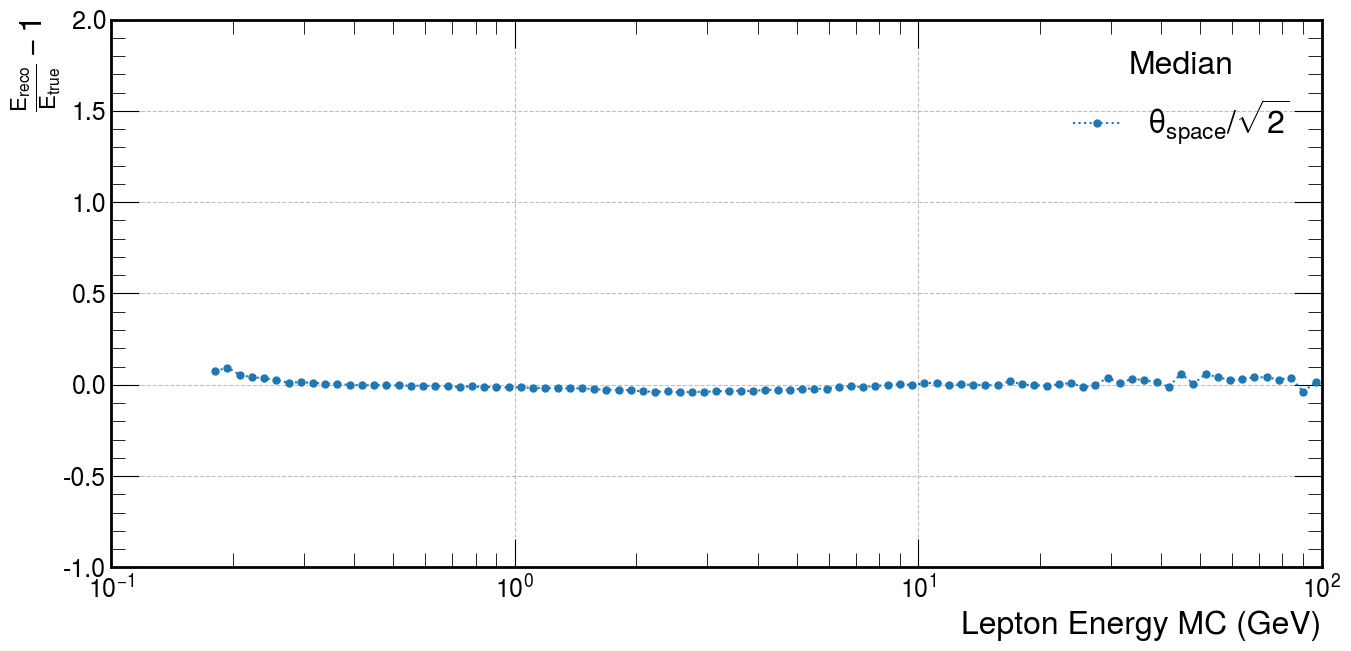

In [233]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                   infotype='median',
                   label=r'$\theta_{space}/\sqrt{2}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)

plt.ylim(-1,2)
# plt.yscale('log')

In [291]:
# Minimize S2 instead

@nb.njit
def minS2(evDT, correct, Ei, a, c):

    rad_length = 14.0
    stepsize = 10
    red_length = stepsize / rad_length
    m_muon = 0.1057

    result = 0
    dei = 0
    # penality = False
    for idx in nb.prange(len(evDT)):
        dth = evDT[idx]
        Eij = Ei[idx]
        # if Eij <= m_muon:
        #     penality=True
        #     Eij = m_muon+0.01
        #     dei = 0
        # else:
        #     dei = np.interp(Eij, E_GeV, dEdx)*stepsize
        # if nonrel_Eij < m_muon:
        #     return 99999

        pij = np.sqrt(Eij*Eij - m_muon*m_muon)
        beta = np.sqrt(1 - ((m_muon*m_muon)/(pij*pij + m_muon*m_muon)))
        tH0 = ( (a/pij**2 + c) / (pij*beta)) * (1.0 + 0.038 * np.log(red_length/beta**2)) * np.sqrt(red_length)
        if correct:
            tH0 *= np.sqrt(2)
        rms_square = tH0**2
        # if evValid[idx] is False:
        #     continue
        prob = -0.5*np.log(2*np.pi) - 0.5*np.log(rms_square) - 0.5*dth*dth/rms_square
        # if penality:
        #     prob -= 2*rms_square
        result-=2*prob
    return result
def call_minS2(a:float, c:float, ev:int):
    global DT
    # global Valid
    global correct
    global Ei
    
    ev = int(ev)
    result = 0
    result = minS2(DT[ev], correct, Ei[ev], a, c)
    return result



In [441]:

def minimizeS2(start=0, maxevt=None, deltatheta = None, _Ei = None, docorrect = True):
    global trueP
    global DT
    global Valid
    global correct
    global Ei
    
    
    
    DT = deltatheta
    correct = docorrect
    Ei = _Ei
    
    indexes = [ i for i, _ in enumerate(DT)]

    if maxevt == None:
        maxevt = len(DT)
    indexes = indexes[start:maxevt]
    p_ = trueP[start:maxevt]
    
    trueE = np.zeros_like(p_)
    resa = np.zeros_like(p_)
    resc = np.zeros_like(p_)
    fitS = np.zeros_like(p_)
    for idx, ev in enumerate(tqdm(indexes)):
        pars = ['a', 'c', 'ev']
        m = Minuit(call_minS2, a=0.105, c=11.1, ev=ev)
        m.fixed['ev'] = True
        m.limits['a'] = (0.01,100)
        m.fixed['a'] = 0.1057
        m.limits['c'] = (0.1,100)
        m.strategy.strategy = 2
        m.migrad()
        vals = [m.values[par] for par in pars]
        pt = p_[idx]
        trueE[idx] = np.sqrt(pt**2 + 0.1057**2)
        resa[idx] = vals[0]
        resc[idx] = vals[1]
        fitS[idx] = m.fmin.is_valid
    trueE = trueE.astype(float)
    resa = resa.astype(float)
    resc = resc.astype(float)
    return trueE, resa, resc , fitS


In [442]:
maxevent=15000
tE, ra, rc, fS = minimizeS2(0,maxevent,thetas, Ei, True)


100%|██████████| 15000/15000 [00:03<00:00, 4064.02it/s]


In [443]:
tEc = tE[isContained[:maxevent]==True]
rac = ra[isContained[:maxevent]==True]
rcc = rc[isContained[:maxevent]==True]
fSc = fS[isContained[:maxevent]==True]

tE = tE[isContained[:maxevent]==False]
ra = ra[isContained[:maxevent]==False]
rc = rc[isContained[:maxevent]==False]
fS = fS[isContained[:maxevent]==False]

<Figure size 1400x600 with 0 Axes>

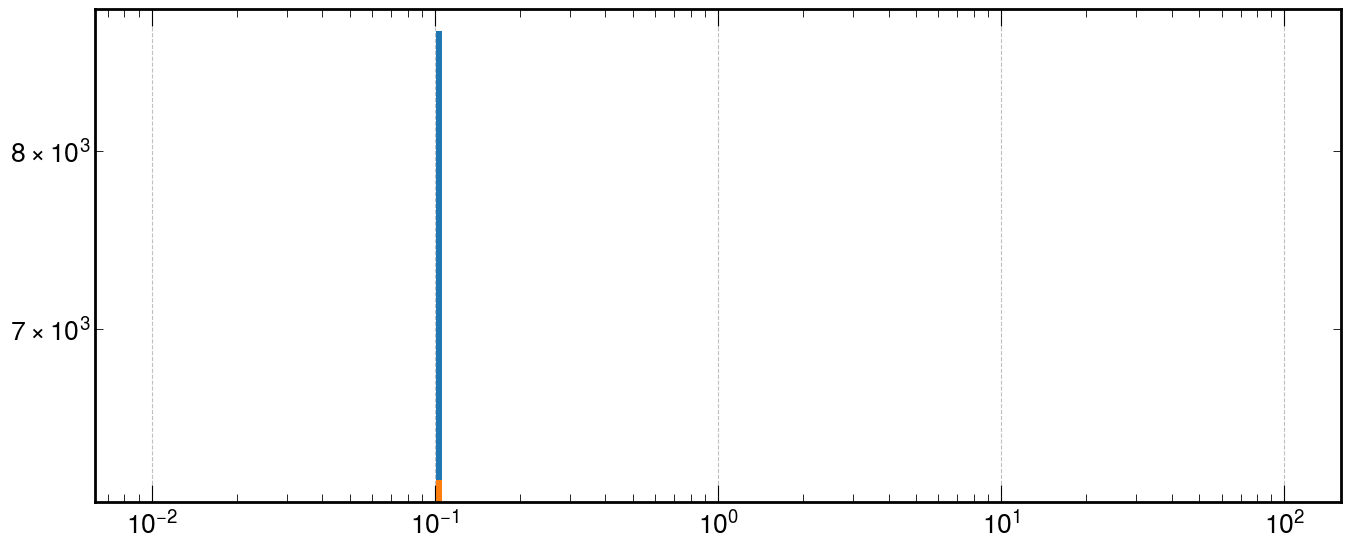

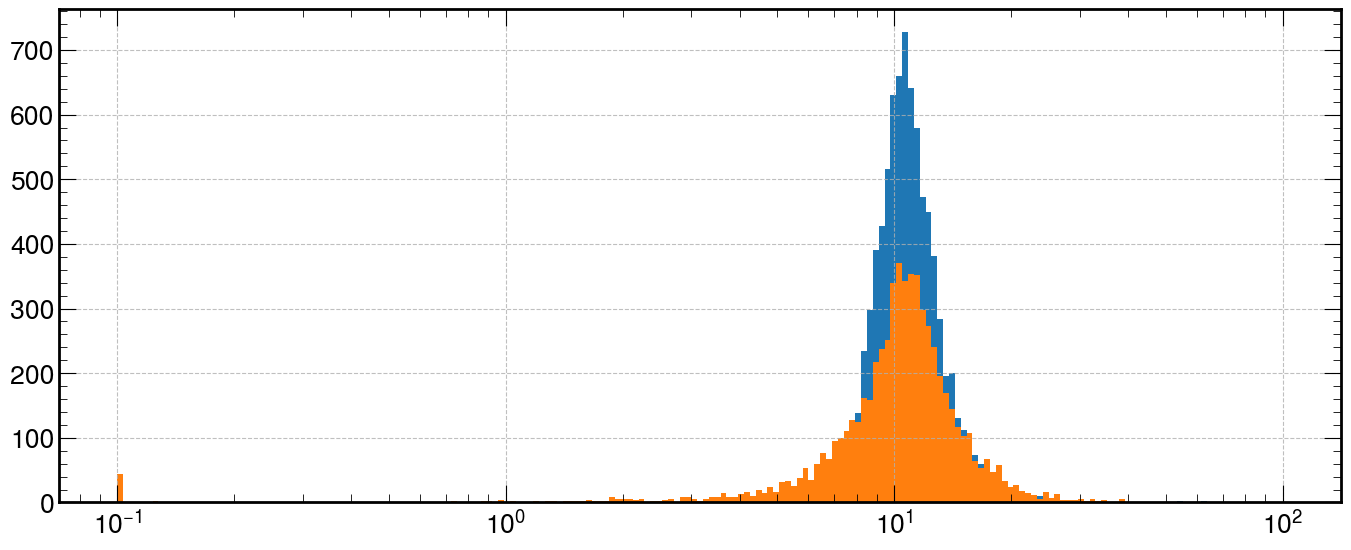

<Figure size 1400x600 with 0 Axes>

In [445]:
plt.hist(ra, bins=np.logspace(-2,2,200));
plt.hist(rac, bins=np.logspace(-2,2,200));
plt.xscale('log')
plt.yscale('log')

plt.figure()
plt.hist(rc, bins=np.logspace(-1,2,200));
plt.hist(rcc, bins=np.logspace(-1,2,200));
plt.xscale('log')



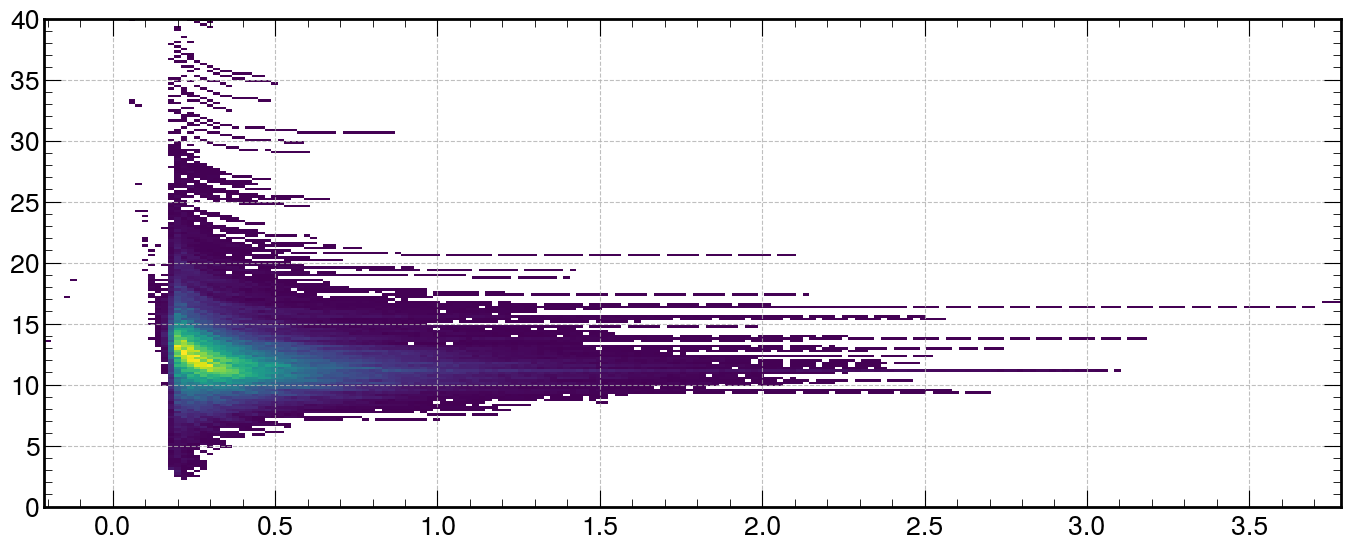

In [480]:
vals_S2 = []
Eicut = Ei[:maxevent][isContained[:maxevent].tolist()]
Ei_p = []
for _Ei,_ra, _rc  in  zip(Eicut, rac,rcc):
    for vEi in _Ei:
        vals_S2.append(fit_s2(vEi, _ra,_rc))
        Ei_p.append(vEi)
plt.hist2d(Ei_p, vals_S2, bins=[200,np.linspace(0,40,200)], cmin=1);


In [240]:
mcana = Anatree("", load_data=False)
mcana.read_parquet('../data/parquet_anatree_mcparticle_dump2/')

dfmcana = mcana.nu.collect()
dfmcana = dfmcana.with_columns(
    E = (pl.col('lep_mom_truth')**2 + 0.1057**2).sqrt(),
    Ellhd = pl.col("RecoLepEnNumu_mcs_llhd"),
).filter(
    (pl.col('nuPDG_truth').abs() == 14) & (pl.col('ccnc_truth')==0)
).filter(
    pl.col('Ellhd') > 0
)


Reading nu files... 60/60
Reading geant files... 60/60
Reading reco_tracks files... 60/60

Reading pfp files... 60/60


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1400x600 with 0 Axes>

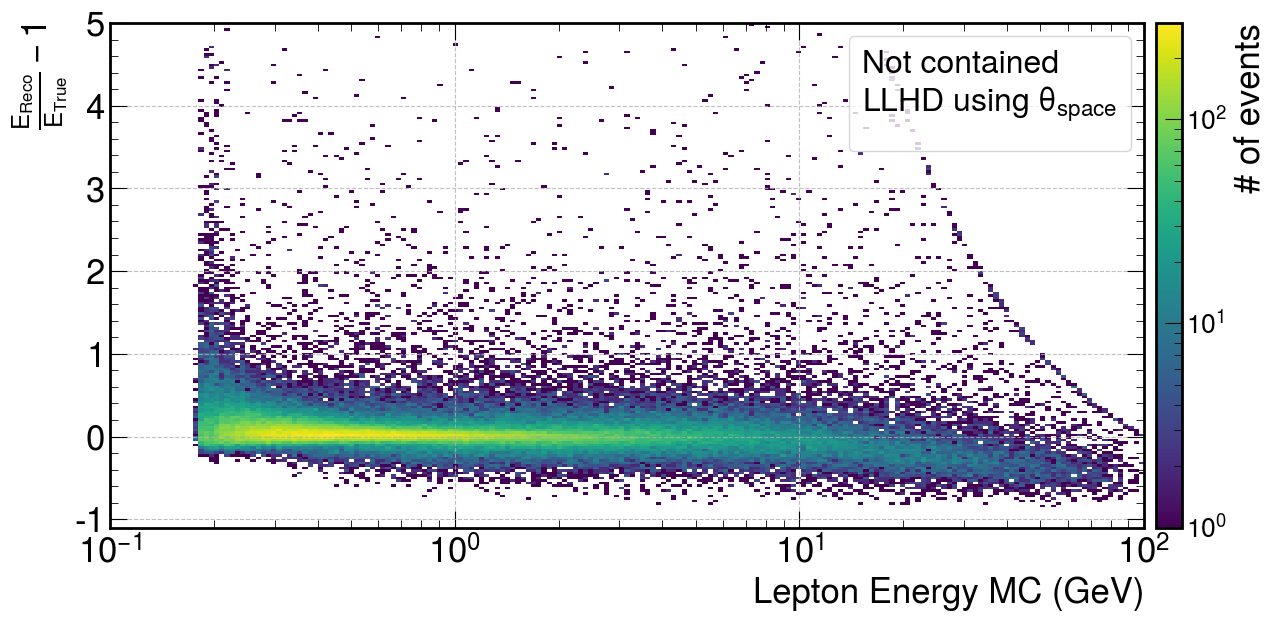

<Figure size 1400x600 with 0 Axes>

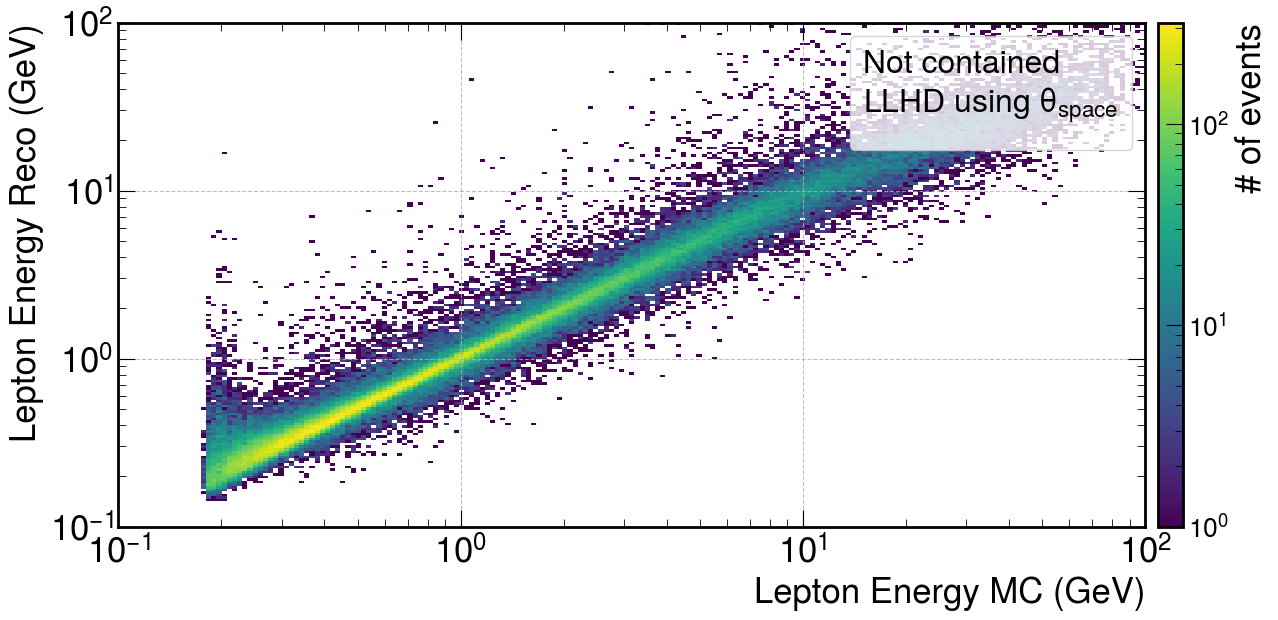

In [241]:
display_en_reco(dfmcana['E'],
                dfmcana['Ellhd'],
                # actualx=recoE_nosqrt
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )
display_en_reco(dfmcana['E'],
                dfmcana['Ellhd'],
                makefrac=False,
                ylabel='Lepton Energy Reco (GeV)',
                binsy=np.logspace(-1,2,200),
                yscale='log',
                lmethod = r"Not contained""\n"r"LLHD using $\theta_{space}$"
                )

(0.0, 35.0)

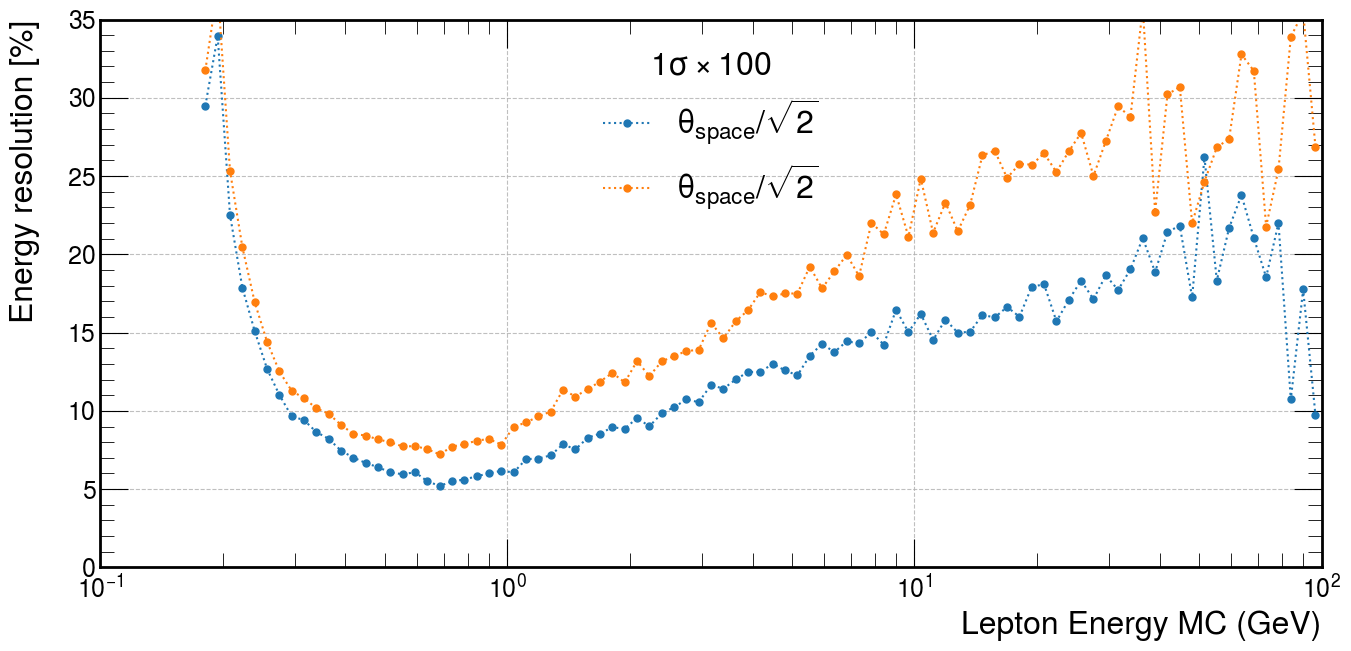

In [244]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                  recoE,
                  label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(dfmcana['E'],
                   dfmcana['Ellhd'],
                  label=r'$\theta_{space}/\sqrt{2}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)
plt.ylim(0,35)

(-1.0, 2.0)

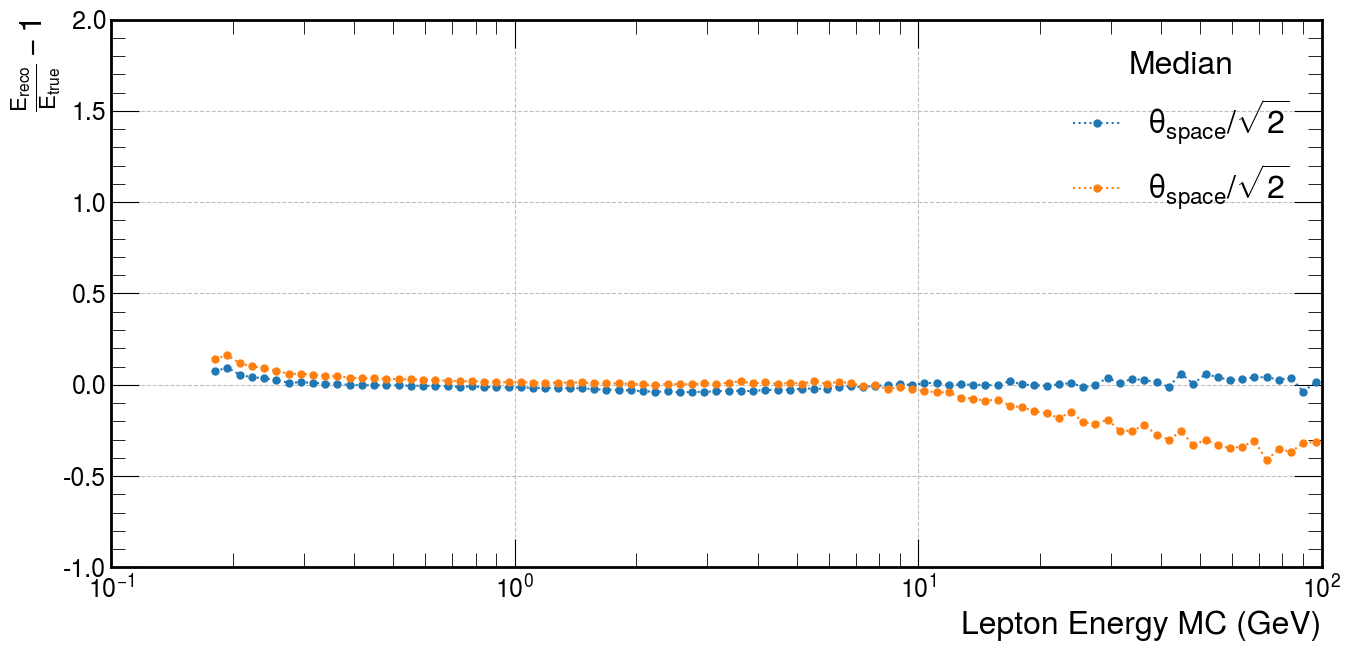

In [242]:
plt.figure(figsize=[14,7])
plot_res_vs_energy(trueE,
                   recoE,
                   infotype='median',
                   label=r'$\theta_{space}/\sqrt{2}$')
plot_res_vs_energy(dfmcana['E'],
                   dfmcana['Ellhd'],
                   infotype='median',
                   label=r'$\theta_{space}/\sqrt{2}$')
plt.xlabel('Lepton Energy MC (GeV)', fontsize=23)

plt.ylim(-1,2)